Lambda School Data Science

*Unit 4, Sprint 3, Module 2*

---

# Convolutional Neural Networks (Prepare)

> Convolutional networks are simply neural networks that use convolution in place of general matrix multiplication in at least one of their layers. *Goodfellow, et al.*

## Learning Objectives
- <a href="#p1">Part 1: </a>Describe convolution and pooling
- <a href="#p2">Part 2: </a>Apply a convolutional neural network to a classification task
- <a href="#p3">Part 3: </a>Use a pre-trained convolution neural network for object detection

Modern __computer vision__ approaches rely heavily on convolutions as both a dimensinoality reduction and feature extraction method. Before we dive into convolutions, let's talk about some of the common computer vision applications: 
* Classification [(Hot Dog or Not Dog)](https://www.youtube.com/watch?v=ACmydtFDTGs)
* Object Detection [(YOLO)](https://www.youtube.com/watch?v=MPU2HistivI)
* Pose Estimation [(PoseNet)](https://ai.googleblog.com/2019/08/on-device-real-time-hand-tracking-with.html)
* Facial Recognition [Emotion Detection](https://www.cbronline.com/wp-content/uploads/2018/05/Mona-lIsa-test-570x300.jpg)
* and *countless* more 

We are going to focus on classification and pre-trained object detection today. What are some of the applications of object detection?

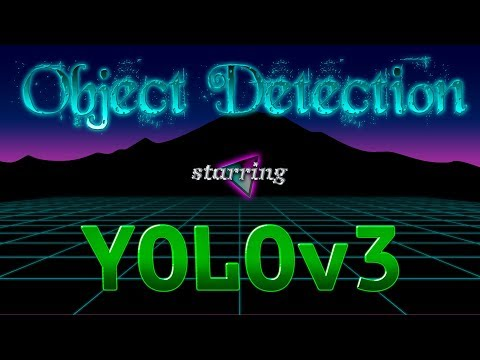

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('MPU2HistivI', width=600, height=400)

# Convolution & Pooling (Learn)
<a id="p1"></a>

## Overview

Like neural networks themselves, CNNs are inspired by biology - specifically, the receptive fields of the visual cortex.

Put roughly, in a real brain the neurons in the visual cortex *specialize* to be receptive to certain regions, shapes, colors, orientations, and other common visual features. In a sense, the very structure of our cognitive system transforms raw visual input, and sends it to neurons that specialize in handling particular subsets of it.

CNNs imitate this approach by applying a convolution. A convolution is an operation on two functions that produces a third function, showing how one function modifies another. Convolutions have a [variety of nice mathematical properties](https://en.wikipedia.org/wiki/Convolution#Properties) - commutativity, associativity, distributivity, and more. Applying a convolution effectively transforms the "shape" of the input.

One common confusion - the term "convolution" is used to refer to both the process of computing the third (joint) function and the process of applying it. In our context, it's more useful to think of it as an application, again loosely analogous to the mapping from visual field to receptive areas of the cortex in a real animal.

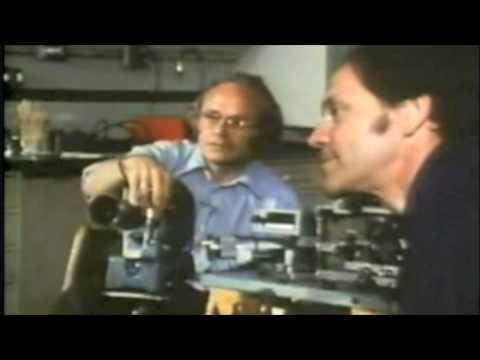

In [2]:
from IPython.display import YouTubeVideo
YouTubeVideo('IOHayh06LJ4', width=600, height=400)

## Follow Along

Let's try to do some convolutions in `Keras`.

### Convolution - an example

Consider blurring an image - assume the image is represented as a matrix of numbers, where each number corresponds to the color value of a pixel.

In [3]:
import imageio
import matplotlib.pyplot as plt
from skimage import color, io
from skimage.exposure import rescale_intensity

austen = io.imread('https://dl.airtable.com/S1InFmIhQBypHBL0BICi_austen.jpg')
austen_grayscale = rescale_intensity(color.rgb2gray(austen))
austen_grayscale

array([[0.0817498 , 0.07782824, 0.07166667, ..., 0.05650118, 0.05650118,
        0.05650118],
       [0.07390667, 0.07390667, 0.07166667, ..., 0.05650118, 0.05650118,
        0.05650118],
       [0.06578078, 0.0699851 , 0.07166667, ..., 0.05650118, 0.05650118,
        0.05650118],
       ...,
       [0.86301294, 0.94453255, 0.96554706, ..., 0.14962275, 0.17065216,
        0.20986784],
       [0.95045608, 0.94989059, 0.97060745, ..., 0.14962275, 0.17821255,
        0.2213498 ],
       [0.95104431, 0.97260941, 0.97117294, ..., 0.15354431, 0.18213412,
        0.2213498 ]])

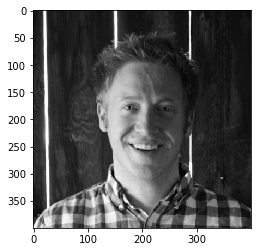

In [4]:
plt.imshow(austen_grayscale, cmap="gray");

In [5]:
austen_grayscale.shape

(400, 400)

In [6]:
import numpy as np
import scipy.ndimage as nd

horizontal_edge_convolution = np.array([[1,1,1,1,1],
                                     [0,0,0,0,0],
                                     [0,0,0,0,0],
                                     [0,0,0,0,0],
                                     [-1,-1,-1,-1,-1]])

vertical_edge_convolution = np.array([[1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1],
                                     [1, 0, 0, 0, -1]])

austen_edges = nd.convolve(austen_grayscale, horizontal_edge_convolution)
austen_edges.shape

(400, 400)

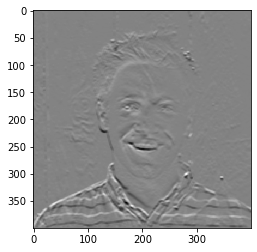

In [7]:
plt.imshow(austen_edges, cmap="gray");

## Challenge

You will be expected to be able to describe convolution. 

# CNNs for Classification (Learn)

## Overview

### Typical CNN Architecture

![A Typical CNN](https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Typical_cnn.png/800px-Typical_cnn.png)

The first stage of a CNN is, unsurprisingly, a convolution - specifically, a transformation that maps regions of the input image to neurons responsible for receiving them. The convolutional layer can be visualized as follows:

![Convolutional layer](https://upload.wikimedia.org/wikipedia/commons/6/68/Conv_layer.png)

The red represents the original input image, and the blue the neurons that correspond.

As shown in the first image, a CNN can have multiple rounds of convolutions, [downsampling](https://en.wikipedia.org/wiki/Downsampling_(signal_processing)) (a digital signal processing technique that effectively reduces the information by passing through a filter), and then eventually a fully connected neural network and output layer. Typical output layers for a CNN would be oriented towards classification or detection problems - e.g. "does this picture contain a cat, a dog, or some other animal?"

Why are CNNs so popular?
1. Compared to prior image learning techniques, they require relatively little image preprocessing (cropping/centering, normalizing, etc.)
2. Relatedly, they are *robust* to all sorts of common problems in images (shifts, lighting, etc.)

Actually training a cutting edge image classification CNN is nontrivial computationally - the good news is, with transfer learning, we can get one "off-the-shelf"!

## Follow Along

In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


from tensorflow.keras import datasets
from tensorflow.keras.models import Sequential, Model # <- May Use
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4242857869346739540
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3181130547
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10369866904789395783
physical_device_desc: "device: 0, name: GeForce GTX 960M, pci bus id: 0000:01:00.0, compute capability: 5.0"
]


In [2]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

NameError: name 'plt' is not defined

In [ ]:
train_images[0].shape

In [ ]:
32*32*3

In [5]:
# Setup Architecture

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 64)          36928     
_________________________________________________________________
flatten (Flatten)            (None, 1024)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                6

In [6]:
# Compile Model

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [7]:
# Fit Model
model.fit(train_images, train_labels, batch_size=256, epochs=3, validation_data=(test_images, test_labels))

Train on 50000 samples, validate on 10000 samples
Epoch 1/3
50000/50000 [==============================] - 9s 175us/sample - loss: 1.7825 - accuracy: 0.3430 - val_loss: 1.5494 - val_accuracy: 0.4421
Epoch 2/3
50000/50000 [==============================] - 6s 121us/sample - loss: 1.4205 - accuracy: 0.4833 - val_loss: 1.3246 - val_accuracy: 0.5217
Epoch 3/3
50000/50000 [==============================] - 6s 121us/sample - loss: 1.2748 - accuracy: 0.5437 - val_loss: 1.2693 - val_accuracy: 0.5445


In [24]:
# Evaluate Model

test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2)

10000/10000 - 1s - loss: 0.8459 - accuracy: 0.7242


## Challenge

You will apply CNNs to a classification task in the module project.

# CNNs for Object Detection (Learn)

## Overview

### Transfer Learning - TensorFlow Hub

"A library for reusable machine learning modules"

This lets you quickly take advantage of a model that was trained with thousands of GPU hours. It also enables transfer learning - reusing a part of a trained model (called a module) that includes weights and assets, but also training the overall model some yourself with your own data. The advantages are fairly clear - you can use less training data, have faster training, and have a model that generalizes better.

https://www.tensorflow.org/hub/

**WARNING** - Dragons ahead!

![Dragon](https://upload.wikimedia.org/wikipedia/commons/thumb/d/d8/Friedrich-Johann-Justin-Bertuch_Mythical-Creature-Dragon_1806.jpg/637px-Friedrich-Johann-Justin-Bertuch_Mythical-Creature-Dragon_1806.jpg)

TensorFlow Hub is very bleeding edge, and while there's a good amount of documentation out there, it's not always updated or consistent. You'll have to use your problem-solving skills if you want to use it!

## Follow Along

In [18]:
import numpy as np

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

def process_img_path(img_path):
  return image.load_img(img_path, target_size=(224, 224))

def img_contains_banana(img):
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  x = preprocess_input(x)
  model = ResNet50(weights='imagenet')
  features = model.predict(x)
  results = decode_predictions(features, top=3)[0]
  print(results)
  for entry in results:
    if entry[1] == 'banana':
      return entry[2]
  return 0.0

In [19]:
import requests

image_urls = ["https://github.com/LambdaSchool/ML-YouOnlyLookOnce/raw/master/sample_data/negative_examples/example11.jpeg",
              "https://github.com/LambdaSchool/ML-YouOnlyLookOnce/raw/master/sample_data/positive_examples/example0.jpeg"]

for _id,img in enumerate(image_urls): 
    r = requests.get(img)
    with open(f'example{_id}.jpg', 'wb') as f:
        f.write(r.content)

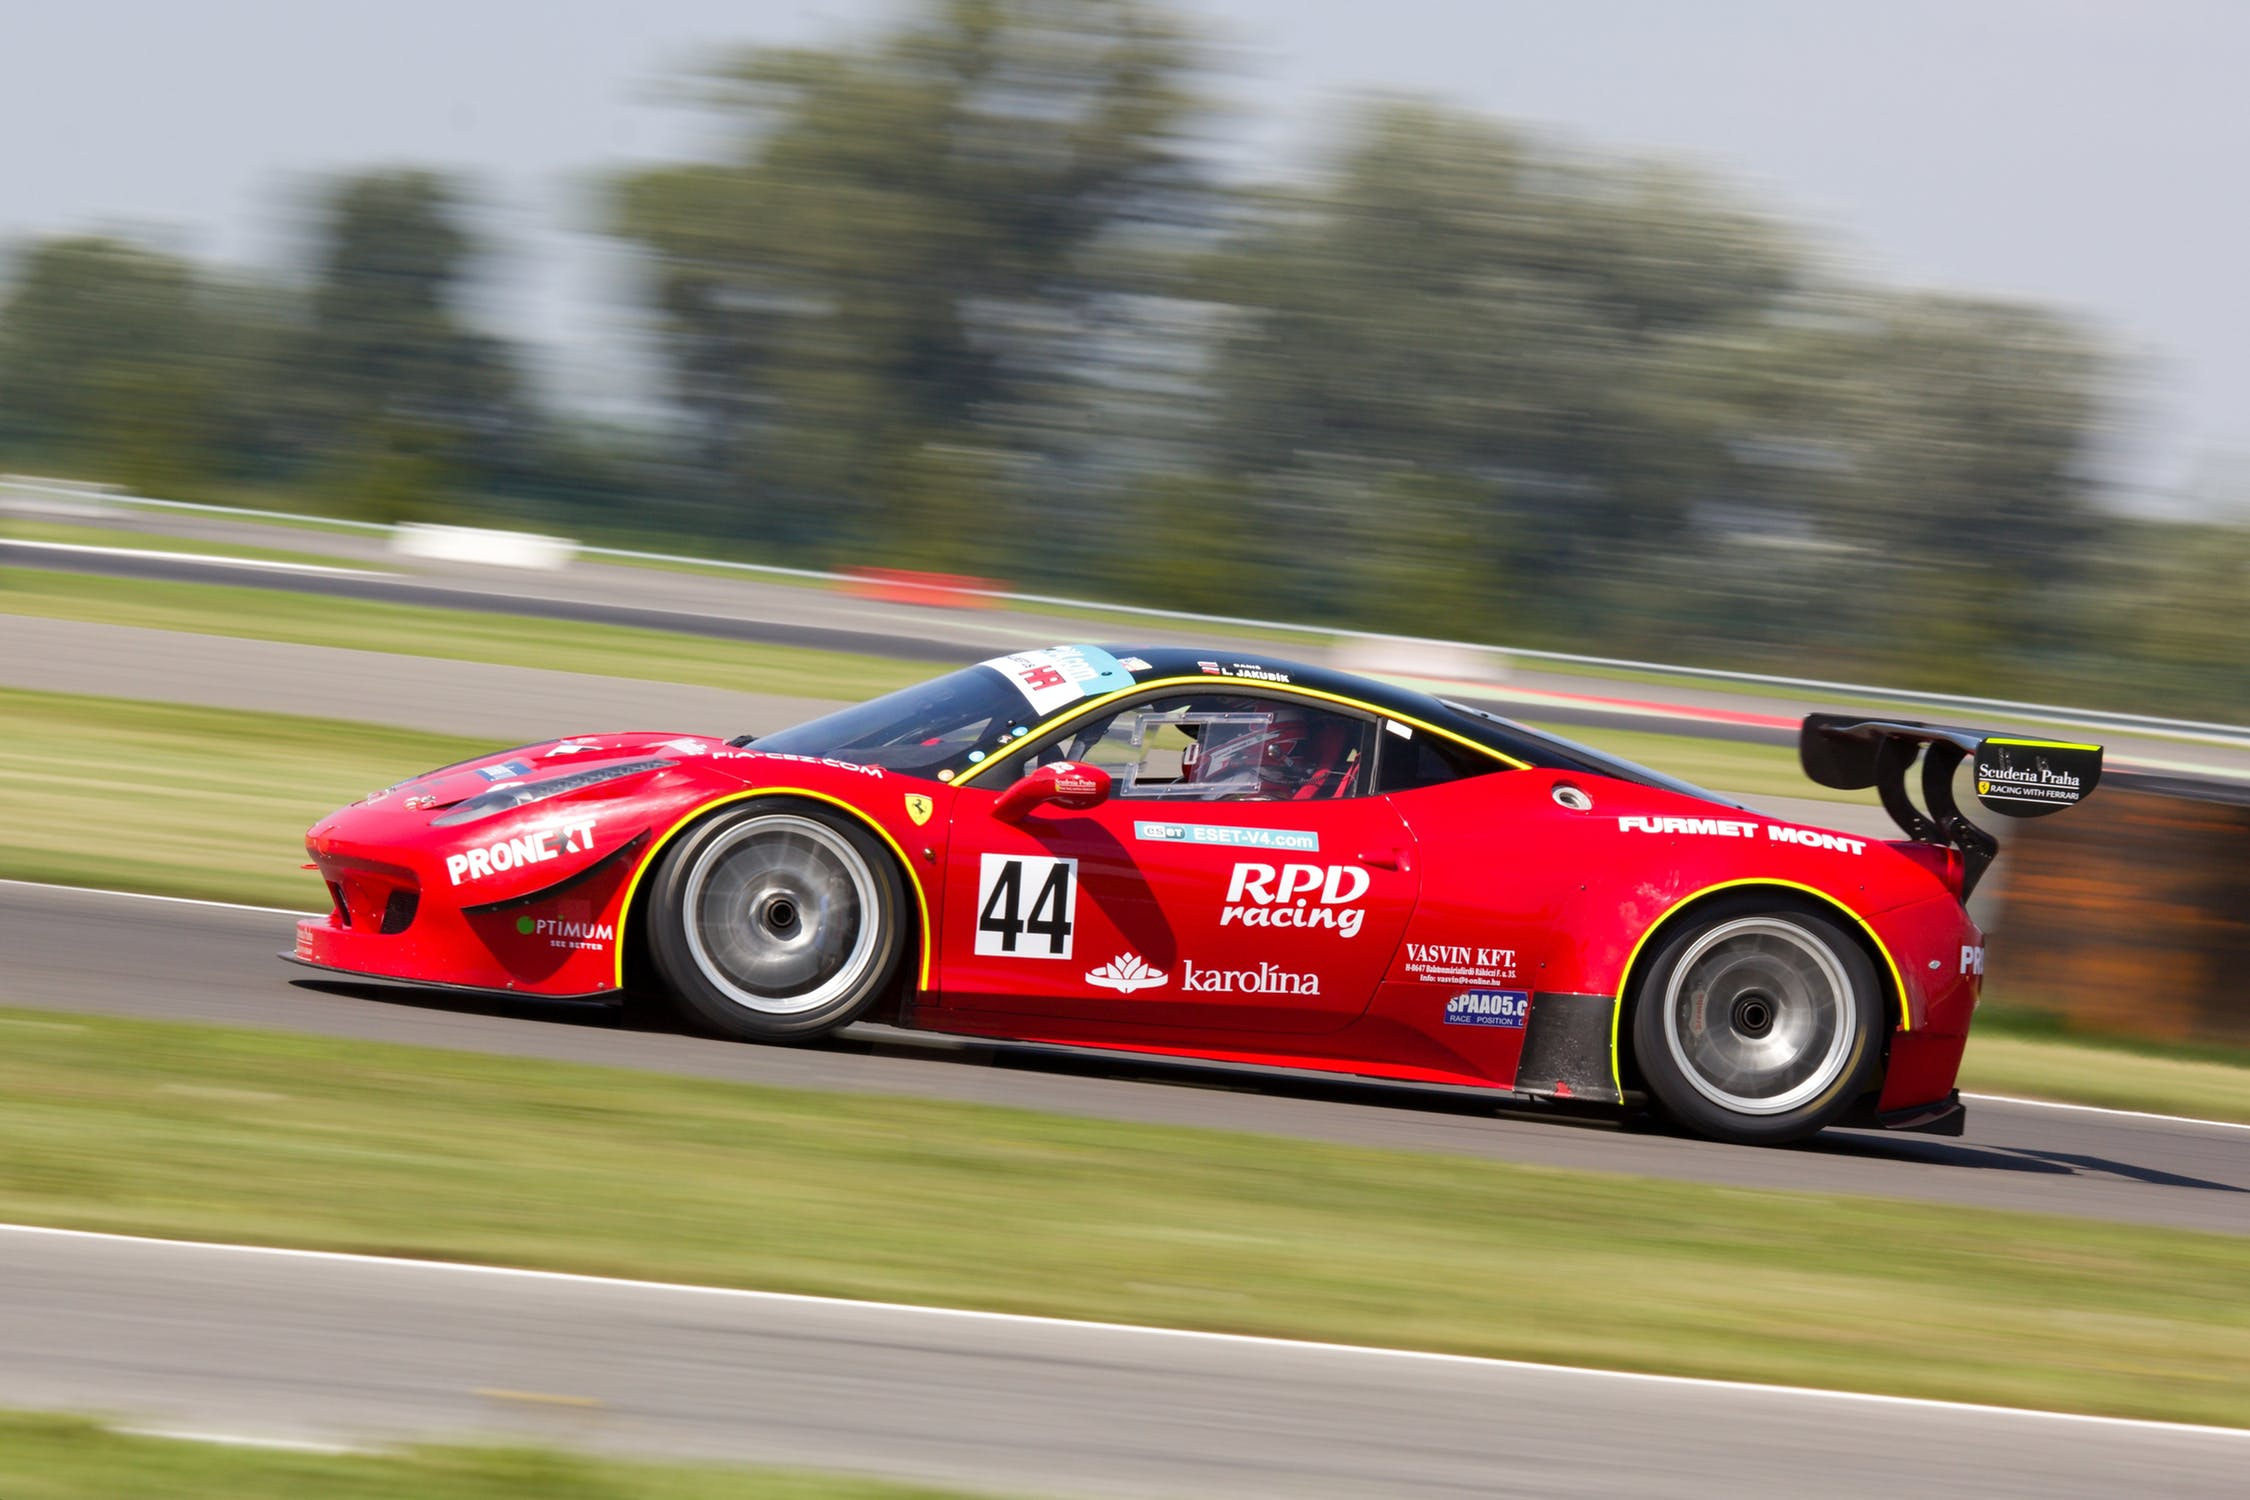

In [20]:
from IPython.display import Image
Image(filename='./example0.jpg', width=600)

In [21]:
img_contains_banana(process_img_path('example0.jpg'))

40960/35363 [==================================] - 0s 1us/step
[('n04037443', 'racer', 0.93360376), ('n04285008', 'sports_car', 0.062752366), ('n04461696', 'tow_truck', 0.0019114049)]


0.0

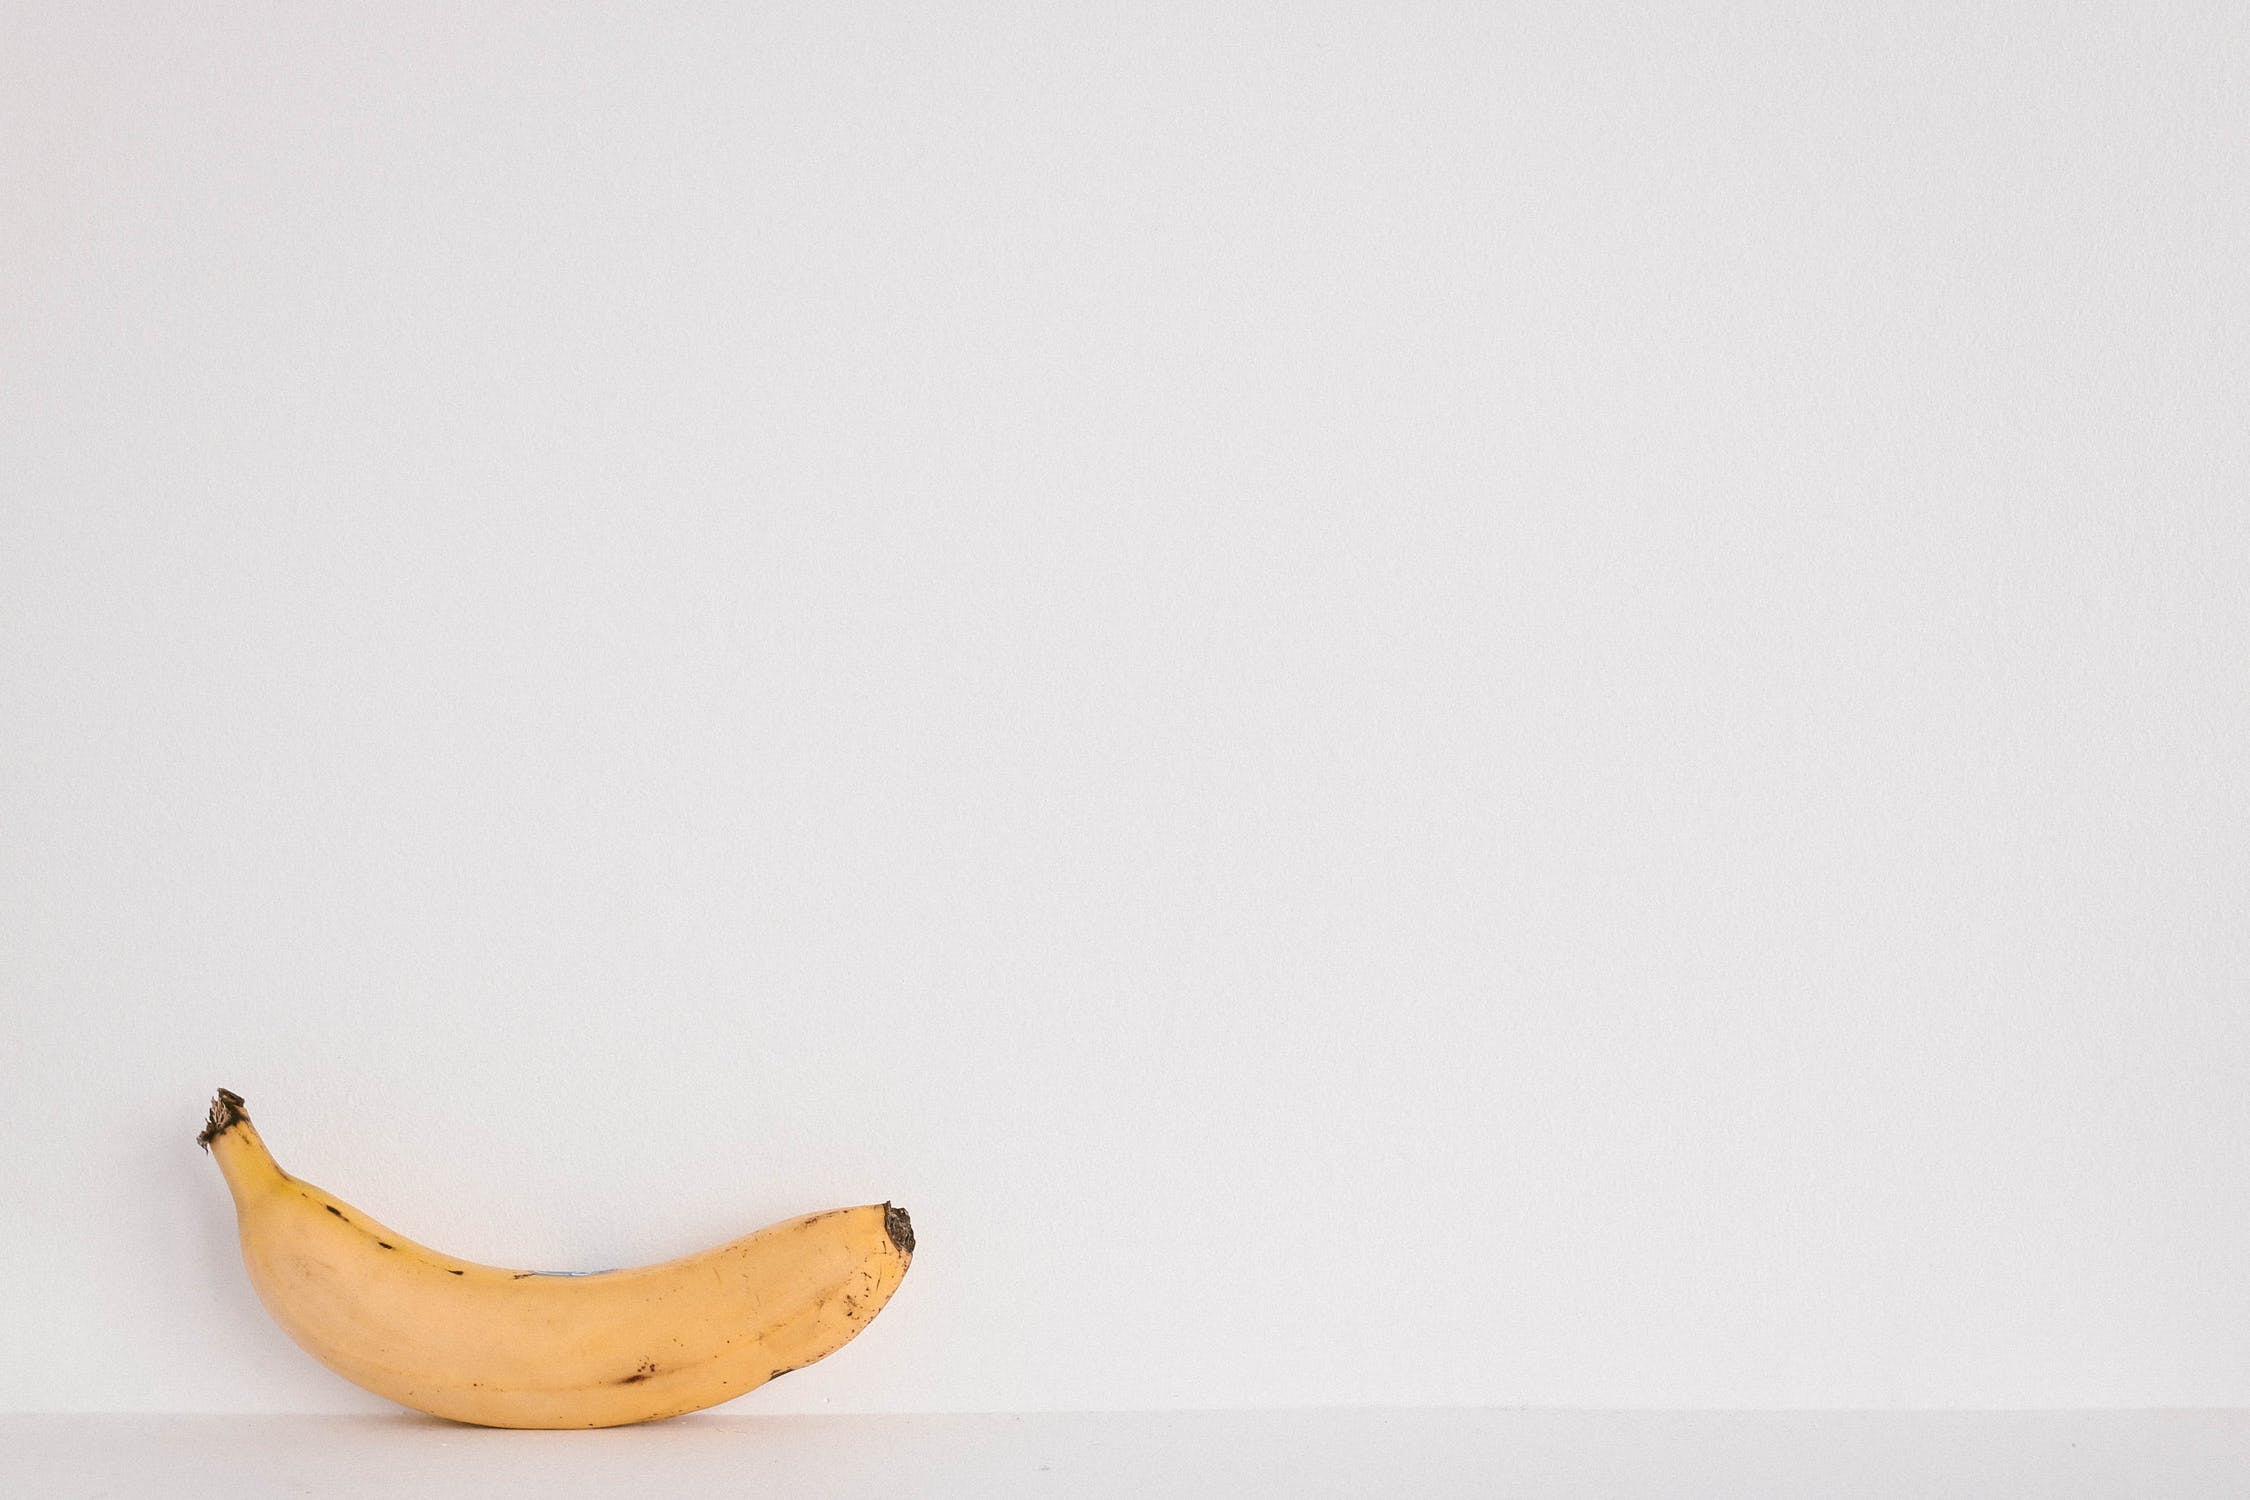

In [22]:
Image(filename='example1.jpg', width=600)

In [23]:
img_contains_banana(process_img_path('example1.jpg'))

[('n03532672', 'hook', 0.078622825), ('n07753592', 'banana', 0.07254702), ('n03498962', 'hatchet', 0.063861236)]


0.07254702

Notice that, while it gets it right, the confidence for the banana image is fairly low. That's because so much of the image is "not-banana"! How can this be improved? Bounding boxes to center on items of interest.

## Challenge

You will be expected to apply a pretrained model to a classificaiton problem today. 

# Review

- <a href="#p1">Part 1: </a>Describe convolution and pooling
    * A Convolution is a function applied to another function to produce a third function
    * Convolutional Kernels are typically 'learned' during the process of training a Convolution Neural Network
    * Pooling is a dimensionality reduction technique that uses either Max or Average of a feature map region to downsample data
- <a href="#p2">Part 2: </a>Apply a convolutional neural network to a classification task
    * Keras has layers for convolutions :) 
- <a href="#p3">Part 3: </a>Use a pre-trained convolution neural network for object detection
    * Check out both pretinaed models available in Keras & TensorFlow Hub

# Sources

- *_Deep Learning_*. Goodfellow *et al.*
- [Keras CNN Tutorial](https://www.tensorflow.org/tutorials/images/cnn)
- [Tensorflow + Keras](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2D)
- [Convolution Wiki](https://en.wikipedia.org/wiki/Convolution)
- [Keras Conv2D: Working with CNN 2D Convolutions in Keras](https://missinglink.ai/guides/keras/keras-conv2d-working-cnn-2d-convolutions-keras/)